# 1-D Convection-Diffusion equation

In this tutorial, we consider the **1D** convection-diffusion equation

$$
\frac{\partial u}{\partial t} + c \partial_x u - \nu \frac{\partial^2 u}{\partial x^2} = 0
$$

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like
from matplotlib.pyplot import plot, show
%matplotlib inline

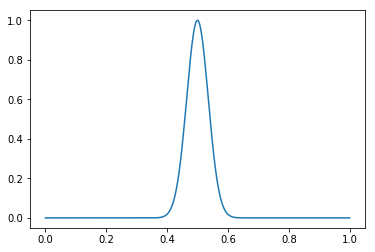

In [2]:
# Initial condition
from numpy import exp
u0 = lambda x: exp(-(x-.5)**2/.05**2)

grid = linspace(0., 1., 401)
u = u0(grid) 
plot(grid, u) ; show()

## Time scheme

$$\frac{u^{n+1}-u^n}{\Delta t}  + c \partial_x u^{n+1} - \nu \partial_{xx} u^{n+1} = 0 $$

$$ \left(I + c \Delta t \partial_x - \nu \Delta t \partial_{xx} \right) u^{n+1} = u^n $$

## Weak formulation

$$
\langle v, u^{n+1} \rangle - c \Delta t ~ \langle \partial_x v, u^{n+1} \rangle + \nu \Delta t ~ \langle \partial_x v, \partial_x u^{n+1} \rangle = \langle v, u^n \rangle
$$
expending $u^n$ over the fem basis, we get the linear system

$$D U^{n+1} = M U^n$$

where

$$
M_{ij} = \langle b_i, b_j \rangle
$$

$$
D_{ij} = \langle b_i, b_j \rangle - c \Delta t ~ \langle \partial_x b_i, b_j \rangle + \nu \Delta t ~ \langle \partial_x b_i, \partial_x b_j \rangle
$$

In [3]:
# needed imports
from spl.linalg.stencil import StencilVector, StencilMatrix
from spl.fem.splines import SplineSpace
from scipy.sparse.linalg import cg, gmres
from utils import assemble_matrix_1d
from utils import assemble_rhs_1d

c = 1     # wavespeed
nu = 0.01   # viscosity
T = 0.2  # T final time
dt = 0.001
niter = int(T / dt)

p  = 3    # spline degree
ne = 64   # number of elements

grid = linspace(0., 1., ne+1)
    
# create a finite element space
V = SplineSpace(p, grid=grid)

In [4]:
# kernel for mass matrix
def kernel_M(p1, k1, basis, w, mat):
    mat[:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis[il_1, 0, g1]
                bi_x = basis[il_1, 1, g1]

                bj_0 = basis[jl_1, 0, g1]
                bj_x = basis[jl_1, 1, g1]

                wvol = w[g1]

                v += (bi_0 * bj_0) * wvol
            mat[il_1, p1 + jl_1 - il_1] = v
            
# kernel for D matrix
def kernel_D(p1, k1, basis, w, mat, c, nu, dt):
    mat[:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis[il_1, 0, g1]
                bi_x = basis[il_1, 1, g1]

                bj_0 = basis[jl_1, 0, g1]
                bj_x = basis[jl_1, 1, g1]

                wvol = w[g1]

                v += (  bi_0 * bj_0 
                      - c * dt * bi_x * bj_0 
                      + nu * dt * bi_x * bj_x) * wvol
            mat[il_1, p1 + jl_1 - il_1] = v

In [5]:
M = assemble_matrix_1d(V, kernel_M).tocsr()
D = assemble_matrix_1d(V, kernel_D, args=(c, nu, dt)).tocsr()

In [6]:
# L2 projection of u0
rhs = assemble_rhs_1d(V, u0).toarray()
un, status = cg(M, rhs, tol=1.e-8, maxiter=5000) 

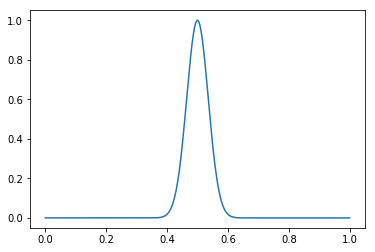

In [7]:
# TODO - to be replaced by the Field evaluation
#      - implement setfromarray 
from scipy.interpolate import splev
def evaluate_field(un, x):
    c_un = zeros_like(V.knots)
    c_un[:len(un)] = un[:]
    tck = (V.knots, c_un, p)
    y = splev( x, tck )
    return y

grid = linspace(0., 1., 401)
plot(grid, evaluate_field(un, grid)) ; show()

In [8]:
for i in range(0, niter):
    b = M.dot(un)
    un, status = gmres(D, b, tol=1.e-8, maxiter=5000)

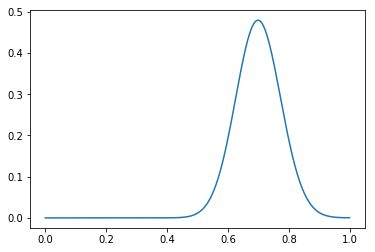

In [9]:
plot(grid, evaluate_field(un, grid)) ; show()

In [10]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()